In [1]:
#from tangostationcontrol.statistics_writer.statistics_writer import main
#import sys
import numpy as np
import matplotlib.pyplot as plt
#from os import listdir
#from os.path import isfile,join
from time import sleep
from datetime import datetime
from astropy.coordinates import EarthLocation
from astropy import units as u

def P2dB(P): return 10*np.log10(np.abs(P))

In [2]:
from xsts import XSTs
import sats 

In [3]:
RCUs = [8,9,10,11]
sis = [3*i+j for i in RCUs for j in range(3)]
print(sis)
xst1=XSTs('xst')

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
XST files= 330 , Bands= [318 319 320 321 322]


In [4]:
LOFARloc=EarthLocation(lat=52.91161366*u.deg,lon=6.86862350*u.deg,height=50.165*u.m)
sat_t_step=2 #seconds

In [5]:
tstart=datetime.fromisoformat("2022-10-28 17:16:00")
tend=datetime.fromisoformat("2022-10-28 17:24:00")
band=322
satfreq=137.1 #MHz
sat_id=40069
sat_name="METEOR-M 2"

In [6]:
tstart=datetime.fromisoformat("2022-10-30 18:50:00")
tend=datetime.fromisoformat("2022-10-30 18:58:00")
band=322
satfreq=137.1 #MHz
sat_id=33591
sat_name="NOAA 19"

In [7]:
tstart=datetime.fromisoformat("2022-10-30 16:35:00")
tend=datetime.fromisoformat("2022-10-30 16:45:00")
band=322
satfreq=137.1 #MHz
sat_id=40069
sat_name="METEOR-M 2"

In [8]:
#Dxst=xst1.GetBand(322,datetime.fromisoformat("2022-10-28 17:12:00"),datetime.fromisoformat("2022-10-28 17:28:00"),sis)
#minutes=np.arange(len(Dxst))*4/60+12
Dxst=xst1.GetBand(band,tstart,tend,sis)
minutes=np.arange(len(Dxst))*4/60+tstart.minute+tstart.second/60

Load XST xst/XST_SB322_2022-10-30-16-16-06.h5


Text(0.5, 1.0, 'Power')

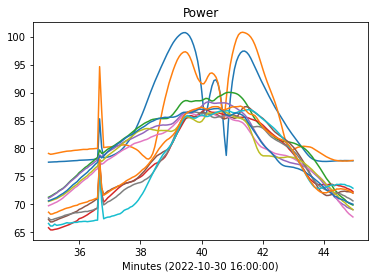

In [9]:
tstarth=tstart.strftime('%Y-%m-%d %H:00:00')
for x in range(12):
    plt.plot(minutes,P2dB(Dxst[:,x,x]))
plt.xlabel("Minutes (%s)"%tstarth)
plt.title("Power")

In [10]:
freq=200-np.arange(512)/512*100
Xdelay_ns=np.array([0.04222275282916484, 0.1703993263909102, -0.08584161326544772, -0.0041436924855575655, 0.21085025845751013, -0.5330351467495102])
XA0_deg=np.array([12.357848905170027, 18.390100221886673, 6.091806627955568, -0.09265135306397794, 22.77566701499772, -43.96238789728221])
Ydelay_ns=np.array([0.9340755943383786, 0.9680985278341058, -0.08454006307776957, 0.10724393218992784, 0.6499148298783806, 1.1771766106105148])
YA0_deg=np.array([81.29843619553783, 98.10616414801521, 0.904688004316736, 0.8912926240329981, 60.486385466544, 107.22814150882617])
corrX=np.exp(2j*np.pi*freq[np.newaxis,:]*(Xdelay_ns/1e3)[:,np.newaxis]-2j*np.pi*XA0_deg[:,np.newaxis]/360)
corrY=np.exp(2j*np.pi*freq[np.newaxis,:]*(Ydelay_ns/1e3)[:,np.newaxis]-2j*np.pi*YA0_deg[:,np.newaxis]/360)

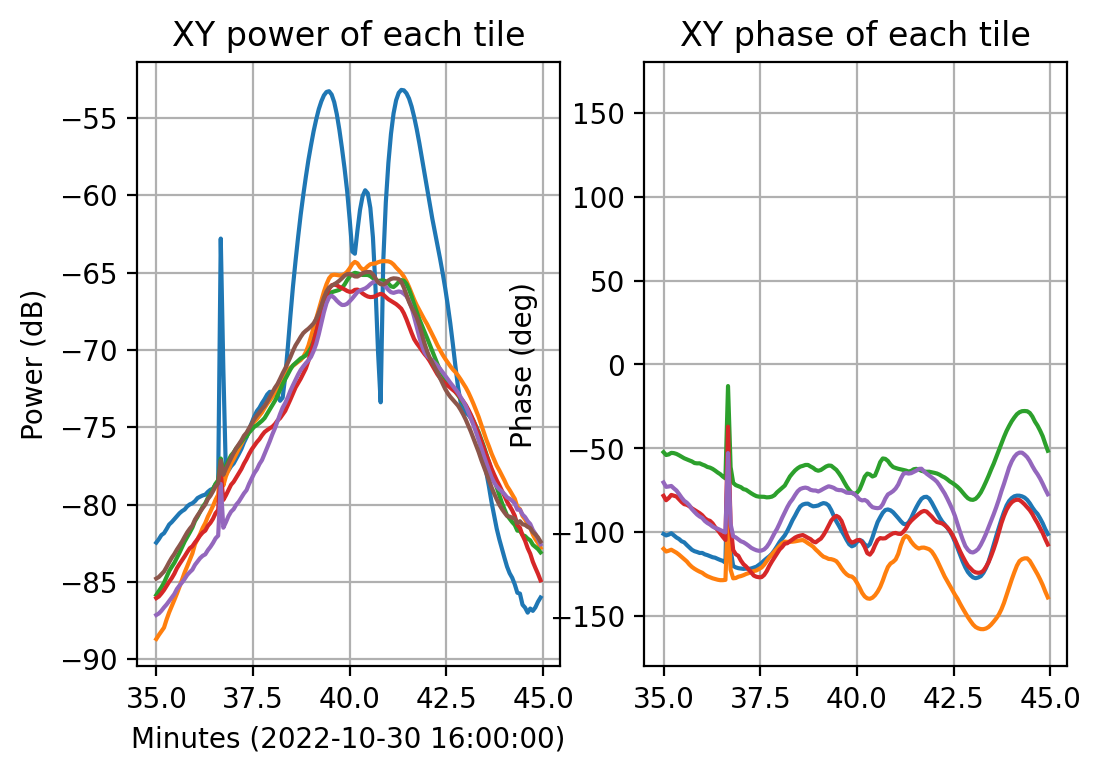

In [11]:
GainADC=(10*np.log10(100e6)+20*np.log10(2**12)) #XST to dBFS
plt.figure(dpi=200)
plt.subplot(1,2,1)
for x in range(6):
    plt.plot(minutes,P2dB(Dxst[:,2*x+1,2*x])-GainADC)
#plt.plot(minutesS,2*P2dB(np.sin(alt/180*np.pi)));

plt.xlabel("Minutes (%s)"%tstarth)
plt.ylabel("Power (dB)")
plt.title("XY power of each tile")
plt.grid()
plt.subplot(1,2,2)
plt.ylim(-180,180)
for x in range(1,6):
    plt.plot(minutes,np.angle(Dxst[:,2*x+1,2*x]/(corrX[x,band]/corrY[x,band]))/np.pi*180)
#    plt.plot(minutes,np.angle(Dxst[:,2*x+1,2*x])/np.pi*180)
plt.ylabel("Phase (deg)")
plt.title("XY phase of each tile")
plt.grid()

Sat name= METEOR-M 2 2022-10-30 16:35:00 2022-10-30 16:45:00 300
Sat freq=137.10MHz  bandfreq=137.11MHz wavelength=2.19 m


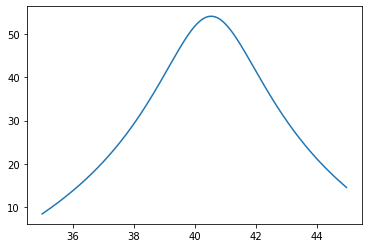

In [12]:
if False:
    print(tstart,tend)
    alt,az=sats.getSatFile("NOAA 19",tstart,tend)
    sat_t_step=10;
else:
    alt,az=sats.calcSat(sat_id,LOFARloc,tstart,tend,sat_t_step)
minutesS=np.arange(len(alt))*sat_t_step/60+tstart.minute+tstart.second//60 #10s step size
az=np.array(az)/180*np.pi
alt=np.array(alt)/180*np.pi
wavelength=300/satfreq;
print("Sat freq=%.2fMHz"%(satfreq)," bandfreq=%.2fMHz"%(200-band/512*100),"wavelength=%.2f m"%wavelength)
plt.plot(minutesS,alt/np.pi*180)

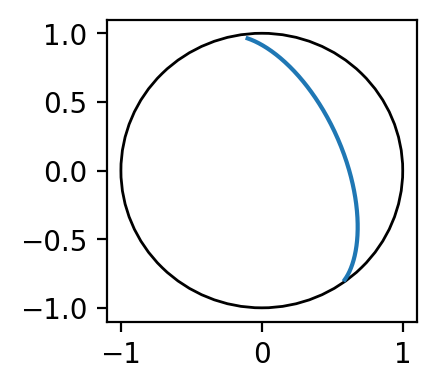

In [13]:
#plt.plot(minutesS,alts);
X=np.cos(alt)*np.sin(az)
Y=np.cos(alt)*np.cos(az)
plt.figure(dpi=200,figsize=(2,2))
ax = plt.gca()
ax.add_patch(plt.Circle((0, 0), 1.0, color='k',fill=False))
plt.plot(X,Y)

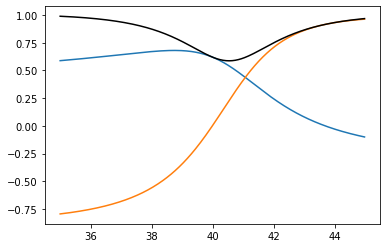

In [14]:
plt.plot(minutesS,X)
plt.plot(minutesS,Y)
plt.plot(minutesS,np.sqrt(Y*Y+X*X),'k-')


In [15]:
def get_baseline_phase(baseline_rot,baseline_dist):
    baseline_rot=baseline_rot/180*np.pi
    baseline=baseline_dist*np.array([np.cos(baseline_rot),np.sin(baseline_rot)]) #m
    print("baseline",baseline)
    lm=(baseline[0]*X+baseline[1]*Y)/wavelength
#    plt.plot(minutesS,lm*360)
    return np.exp(2j*np.pi*lm)
#plt.plot(minutesS,np.angle(Dsat))


baseline [-4.65908183  2.07435688]
baseline [2.07435688 4.65908183]


Text(0.5, 0, 'Minutes (2022-10-30 16:00:00)')

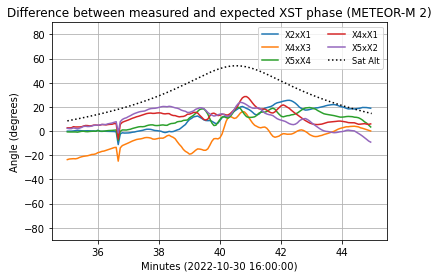

In [16]:
HBArot=24 #HBArotation in degrees
HBAdist=5.1
min_offset=0
pairs1=[[1,2],[3,4],[4,5]]
Dsat=get_baseline_phase((90+90-HBArot),HBAdist)
calibrate=True
for p1,p2 in pairs1:
    Dint=Dxst[:,2*p2,2*p1]#np.interp(minutesS-min_offset,minutes,Dxst[:,2*p2,2*p1])
    if calibrate: Dint=Dint/(corrX[p1,band]/corrX[p2,band])
    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
    plt.plot(minutes,np.unwrap(np.angle(Dint/Dsat2))/np.pi*180,label='X%ixX%i'%(p2,p1))
#    plt.plot(minutes,np.unwrap(np.angle(Dint/Dsat2))/np.pi*180)
#    plt.plot(minutes,np.angle(Dint/(corrX[p1,band]/corrX[p2,band]))/np.pi*180,'y:')
#plt.gca().set_prop_cycle(None)
#for p1,p2 in pairs1:
#    Dint=Dxst[:,2*p2+1,2*p1+1]
#    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
#    plt.plot(minutes,np.unwrap(np.angle(Dint/(corrY[p1,band]/corrY[p2,band])/Dsat2))/np.pi*180,':')
#    plt.plot(minutesS,np.angle(Dint/(corrY[p1,band]/corrY[p2,band])),':')
#plt.plot(minutesS,np.angle(Dsat)/np.pi*180,'k:')
plt.ylim(-180,180)
plt.grid()

Dsat=get_baseline_phase((90-HBArot),HBAdist)
pairs1=[[1,4],[2,5]]
for p1,p2 in pairs1:
    Dint=Dxst[:,2*p2,2*p1]#np.interp(minutesS-min_offset,minutes,Dxst[:,2*p2,2*p1])
    if calibrate: Dint=Dint/(corrX[p1,band]/corrX[p2,band])
    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
    plt.plot(minutes,np.unwrap(np.angle(Dint/Dsat2))/np.pi*180,label='X%ixX%i'%(p2,p1))
#    plt.plot(minutes,np.angle(Dint/(corrX[p1,band]/corrX[p2,band]))/np.pi*180,'g:')
#plt.gca().set_prop_cycle(None)
#for p1,p2 in pairs1:
#    Dint=np.interp(minutesS,minutes,Dxst[:,2*p2+1,2*p1+1])
#    plt.plot(minutesS,np.unwrap(np.angle(-Dint/(corrY[p1,band]/corrY[p2,band])/Dsat)),':')
#plt.plot(minutesS,np.angle(Dsat)/np.pi*180,'b:')
plt.plot(minutesS,alt/np.pi*180,'k:',label='Sat Alt')
plt.legend(fontsize='small',ncol=2)
plt.ylim(-90,90)
plt.title("Difference between measured and expected XST phase (%s)"%sat_name)
plt.ylabel("Angle (degrees)")
plt.xlabel("Minutes (%s)"%tstarth)


baseline [-4.65908183  2.07435688]
baseline [2.07435688 4.65908183]


Text(0.5, 0, 'Minutes (2022-10-30 16:00:00)')

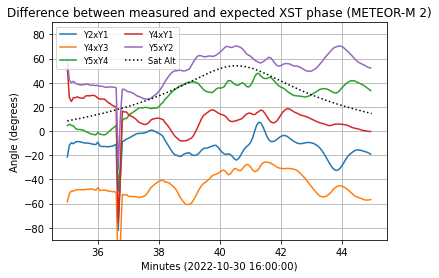

In [17]:
HBArot=24 #HBArotation in degrees
HBAdist=5.1
min_offset=0
pairs1=[[1,2],[3,4],[4,5]]
Dsat=get_baseline_phase((90+90-HBArot),HBAdist)
for p1,p2 in pairs1:
    Dint=Dxst[:,2*p2+1,2*p1+1]#np.interp(minutesS-min_offset,minutes,Dxst[:,2*p2,2*p1])
    if calibrate: Dint=Dint/(corrY[p1,band]/corrY[p2,band])
    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
    plt.plot(minutes,np.unwrap(np.angle(Dint/Dsat2))/np.pi*180,label='Y%ixY%i'%(p2,p1))
#plt.plot(minutesS,np.angle(Dsat)/np.pi*180,'k:')
plt.ylim(-180,180)
plt.grid()

Dsat=get_baseline_phase((90-HBArot),HBAdist)
pairs1=[[1,4],[2,5]]
for p1,p2 in pairs1:
    Dint=Dxst[:,2*p2+1,2*p1+1]#np.interp(minutesS-min_offset,minutes,Dxst[:,2*p2,2*p1])
    if calibrate: Dint=Dint/(corrY[p1,band]/corrY[p2,band])
    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
    plt.plot(minutes,np.unwrap(np.angle(Dint/Dsat2))/np.pi*180,label='Y%ixY%i'%(p2,p1))
#plt.plot(minutesS,np.angle(Dsat)/np.pi*180,'b:')
plt.plot(minutesS,alt/np.pi*180,'k:',label='Sat Alt')
plt.legend(fontsize='small',ncol=2)
plt.ylim(-90,90)
plt.title("Difference between measured and expected XST phase (%s)"%sat_name)
plt.ylabel("Angle (degrees)")
plt.xlabel("Minutes (%s)"%tstarth)



baseline [-4.65908183  2.07435688]


(50.0, 58.0)

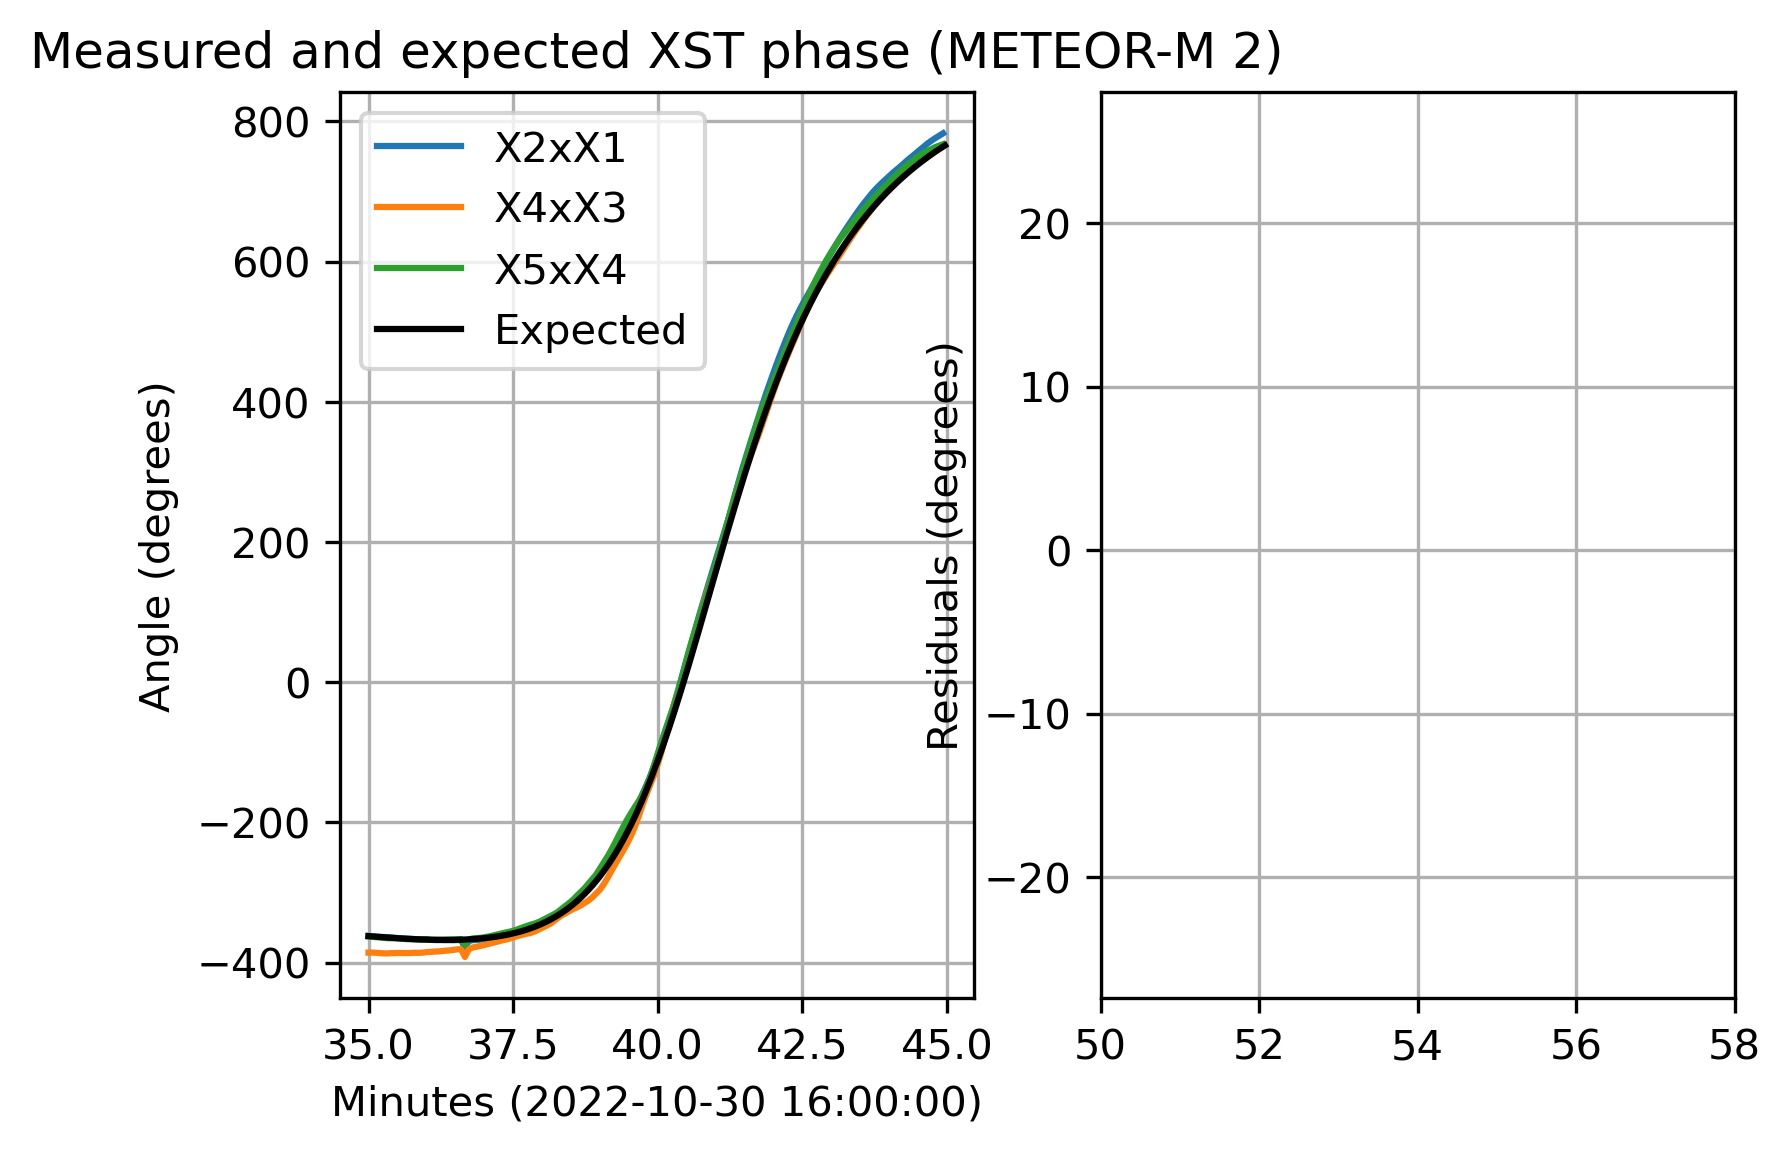

In [18]:
plt.figure(dpi=300)
HBArot=24 #HBArotation in degrees
HBAdist=5.1
min_offset=0
pairs1=[[1,2],[3,4],[4,5]]
Dsat=get_baseline_phase((90+90-HBArot),HBAdist)
calibrate=True

plt.subplot(1,2,1)
plt.title("Measured and expected XST phase (%s)"%sat_name)
for p1,p2 in pairs1:
    Dint=Dxst[:,2*p2,2*p1]#np.interp(minutesS-min_offset,minutes,Dxst[:,2*p2,2*p1])
    if calibrate: Dint=Dint/(corrX[p1,band]/corrX[p2,band])
    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
    plt.plot(minutes,np.unwrap(np.angle(Dint))/np.pi*180-360,label='X%ixX%i'%(p2,p1))
plt.plot(minutesS,np.unwrap(np.angle(Dsat))/np.pi*180-360,'k-',label='Expected')
plt.ylabel("Angle (degrees)")
plt.xlabel("Minutes (%s)"%tstarth)
plt.grid()
plt.legend(ncol=1)

plt.subplot(1,2,2)
for p1,p2 in pairs1:
    Dint=Dxst[:,2*p2,2*p1]#np.interp(minutesS-min_offset,minutes,Dxst[:,2*p2,2*p1])
    if calibrate: Dint=Dint/(corrX[p1,band]/corrX[p2,band])
    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
    plt.plot(minutes,np.unwrap(np.angle(Dint/Dsat2))/np.pi*180,label='X%ixX%i'%(p2,p1))
#plt.plot(minutesS,np.unwrap(np.angle(Dsat))/np.pi*180-360,'k-',label='Expected')
plt.ylabel("Residuals (degrees)")

#plt.ylim(-180,180)
plt.grid()
plt.xlim(50,58)


baseline [-4.65908183  2.07435688]


(50.0, 58.0)

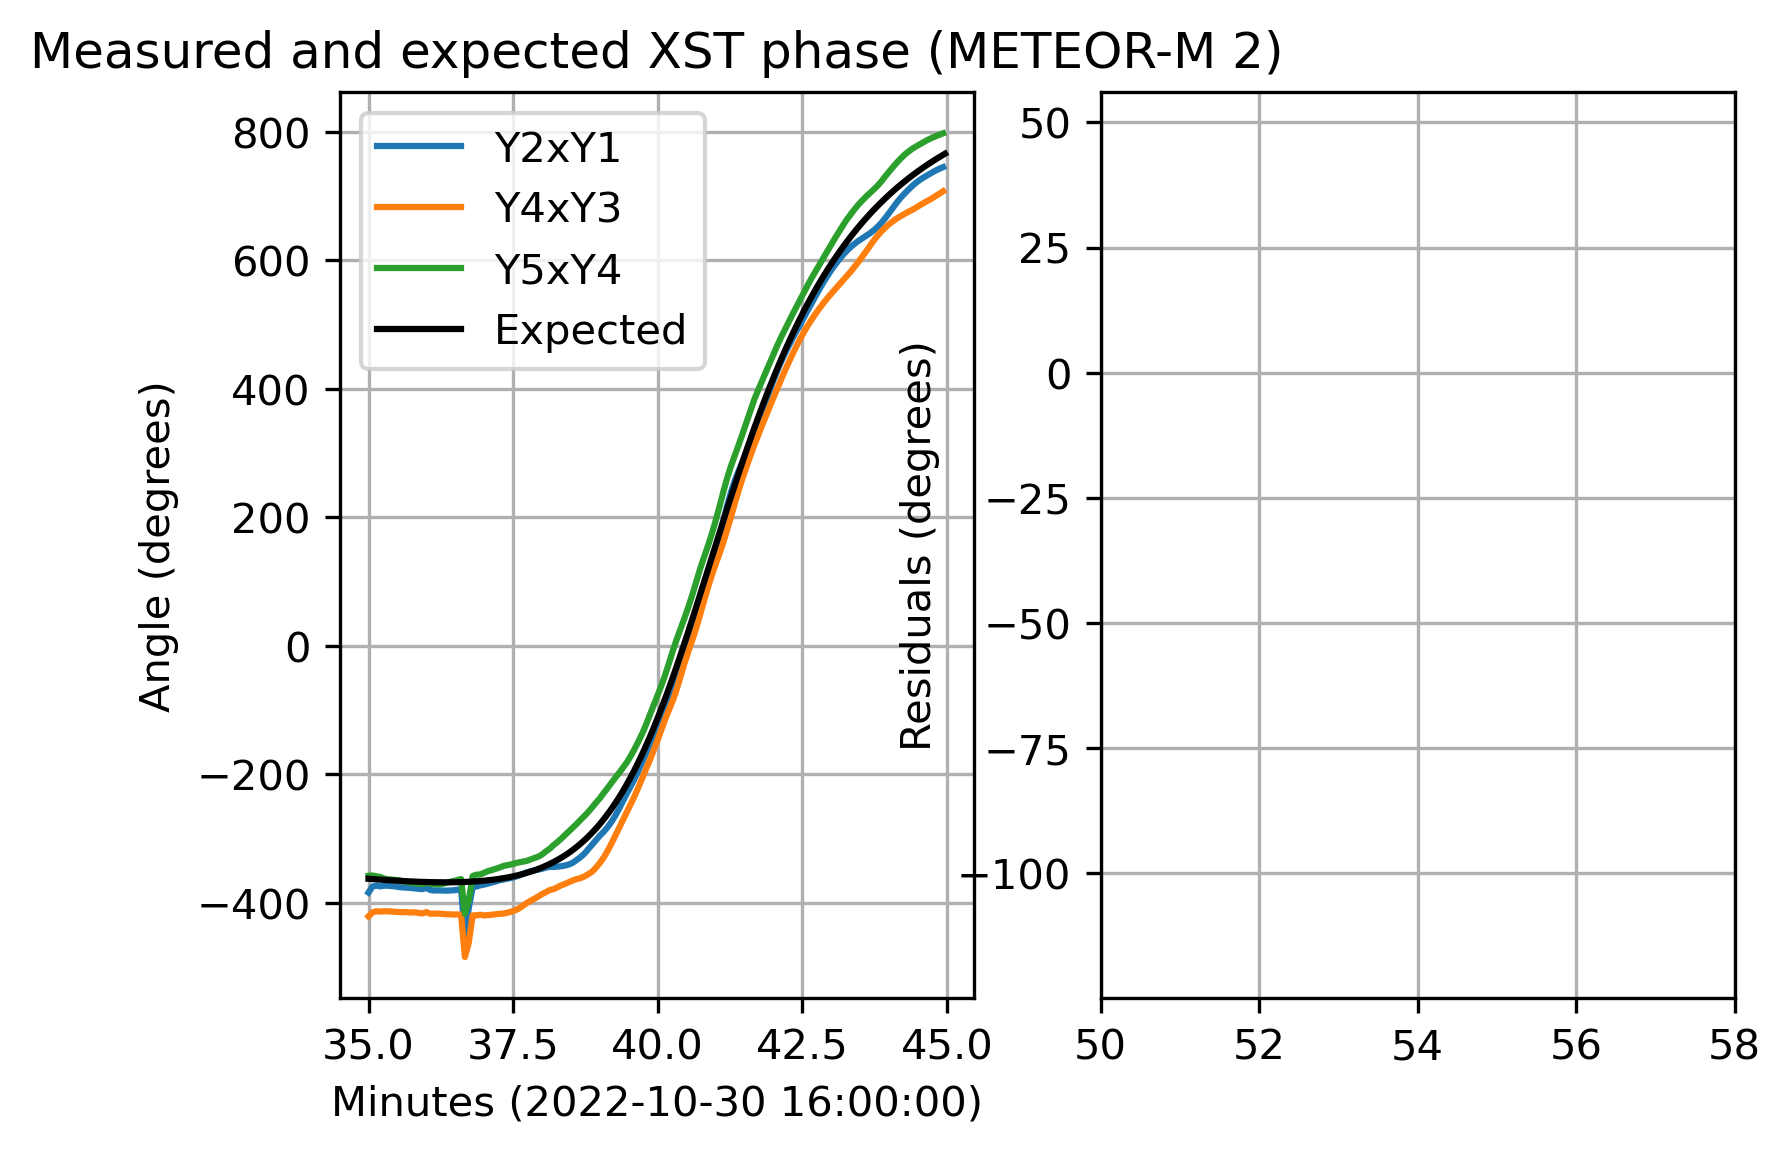

In [20]:
plt.figure(dpi=300)
HBArot=24 #HBArotation in degrees
HBAdist=5.1
min_offset=0
pairs1=[[1,2],[3,4],[4,5]]
Dsat=get_baseline_phase((90+90-HBArot),HBAdist)
calibrate=True

plt.subplot(1,2,1)
plt.title("Measured and expected XST phase (%s)"%sat_name)
for i,(p1,p2) in enumerate(pairs1):
    Dint=Dxst[:,2*p2+1,2*p1+1]#np.interp(minutesS-min_offset,minutes,Dxst[:,2*p2,2*p1])
    if calibrate: Dint=Dint/(corrY[p1,band]/corrY[p2,band])
    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
#    offset=(360*2 if i==1 else 360)
    offset=360
    plt.plot(minutes,np.unwrap(np.angle(Dint))/np.pi*180-offset,label='Y%ixY%i'%(p2,p1))
plt.plot(minutesS,np.unwrap(np.angle(Dsat))/np.pi*180-360,'k-',label='Expected')
plt.ylabel("Angle (degrees)")
plt.xlabel("Minutes (%s)"%tstarth)
plt.grid()
plt.legend(ncol=1)

plt.subplot(1,2,2)
for p1,p2 in pairs1:
    Dint=Dxst[:,2*p2+1,2*p1+1]#np.interp(minutesS-min_offset,minutes,Dxst[:,2*p2,2*p1])
    if calibrate: Dint=Dint/(corrY[p1,band]/corrY[p2,band])
    Dsat2=np.interp(minutes-min_offset,minutesS,Dsat)
    plt.plot(minutes,np.unwrap(np.angle(Dint/Dsat2))/np.pi*180,label='Y%ixY%i'%(p2,p1))
#plt.plot(minutesS,np.unwrap(np.angle(Dsat))/np.pi*180-360,'k-',label='Expected')
plt.ylabel("Residuals (degrees)")

#plt.ylim(-180,180)
plt.grid()
plt.xlim(50,58)
